# Anneal Schedule
This notebook explores features that give you control over the D-Wave system's global [anneal schedule](#Understanding-the-Anneal-Schedule). These features can improve solutions to a problem and provide insight into the behaviour and dynamics of problems undergoing quantum annealing.

1. [Understanding the Anneal Schedule](#Understanding-the-Anneal-Schedule) explains the feature.
2. [Using Anneal Schedule Features](#Using-Anneal-Schedule-Features) shows how to use the feature with an interactive example problem.
3. [Mapping Various Anneal Schedules](#Mapping-Various-Anneal-Schedules-on-the-QPU) provides code that sweeps through various anneal schedules to explore the effect on results.

Uses of the feature are described, for example, in [The power of pausing](https://arxiv.org/abs/1810.05881) 
<div class="alert alert-warning" role="alert" style="margin: 10px">
Note that the final section of this Jupyter Notebook sends a large number of problems to the QPU, takes several minutes to complete, and uses tens of seconds of QPU time. If your account has a limited quota, consider running only the first sections (and not using the Run All menu option).   
</div>

**New to Jupyter Notebooks?** JNs are divided into text or code cells. Pressing the **Run** button in the menu bar moves to the next cell. Code cells are marked by an "In: \[\]" to the left; when run, an asterisk displays until code completion: "In: \[\*\]".

## Feature Availability

Availability of the anneal schedule features depends on the solver you connect to. To see whether your solver supports anneal schedule features, check solver property `max_anneal_schedule_points`  and ensure it is at least 4. 

First, we set up a connection to the quantum processing unit (QPU). Enter your token value if required.

In [8]:
from dwave.system.samplers import DWaveSampler
sampler = DWaveSampler()
print("Connected to sampler", sampler.solver.name)

Connected to sampler Advantage_system4.1


In [9]:
print("Maximum anneal schedule points: {}".format(sampler.properties["max_anneal_schedule_points"]))

Maximum anneal schedule points: 12


Your code can ensure a solver supports the feature by making it a selection criteria: `sampler = DWaveSampler(solver={'max_anneal_schedule_points__gte': 4})` selects only a QPU that supports at least 4 anneal-schedule points.

## Understanding the Anneal Schedule

The [Getting Started with the D-Wave System](https://docs.dwavesys.com/docs/latest/doc_getting_started.html) document describes quantum annealing and the [Solver Properties and Parameters](https://docs.dwavesys.com/docs/latest/doc_solver_ref.html) book describes the parameters used here.

In brief, *anneal schedule* refers to the global annealing trajectory. It specifies the normalized anneal fraction, $s$, an abstract parameter ranging from 0 to 1. $s(t)$ is a continuous function starting at $s=0$ for time $t=0$ and ending with $s=1$ at $t=t_f$, the total time of the anneal.

There are two ways to specify the anneal schedule, using two *mutually exclusive* parameters:

1. `annealing_time`: Set to a number in microseconds to specify linear growth from $s=0$ to $s=1$ over that time.
2. `annealing_schedule`: Specify a list of ($t$, $s$) pairs specifying points, which are then linearly interpolated. This feature supports two modes &mdash; mid-anneal *pause* and mid-anneal *quench* &mdash; which this tutorial explores.
   
<div class="alert alert-warning" role="alert" style="margin: 10px">
It is an error to specify both `annealing_time` and `annealing_schedule`.
</div>

The slope of a line segment is specified as $m_q = \frac{\Delta s}{\Delta t}$, with units of $\mu s^{-1}$. The maximum slope is equal to the inverse of the minimum anneal time. For example, a quench slope of $m_q = 0.5$ is equivalent to a 2 $\mu s$ standard anneal. The cell below calculates the maximum slope for your sampler.

In [10]:
annealing_range = sampler.properties["annealing_time_range"]
max_slope = 1.0/annealing_range[0]
print("Annealing time range: {}".format(sampler.properties["annealing_time_range"]))
print("Maximum slope:", max_slope)

Annealing time range: [0.5, 2000.0]
Maximum slope: 2.0


A number of rules must be followed when building an anneal schedule:

* The first point must be (0,0).
* Normalized anneal fraction $s$ must increase monotonically.
* In the final point, $s$ must equal 1 and time $t$ must not exceed the maximum value in the `annealing_time_range` property.
* The number of points must be $\ge 2$. The upper bound is system-dependent &mdash; check the `max_anneal_schedule_points` property.
* The slopes of each line segment must not violate the maximum slope $m_{max}$.

**Violating these rules returns an error.** Additional rules that govern maximum slope vary by system; check the QPU properties document for your system. 

The sections below demonstrate three schedule variations: 

* [Pause](#Pause) 
* [Quench](#Quench) 
* [Pause and Quench](#Pause-and-Quench)

### Pause

This section creates an anneal schedule with a pause of 200 $\mu s$ halfway through a 100 $\mu s$ anneal. The following code specifies four points: (1) start of anneal, (2) beginning of pause, (3) end of pause, and (4) end of anneal.

(1) Anneal begins at point $[0, 0]$. 

(2 & 3) Anneal continues until half-way through a $100 \mu s$ anneal; that is, time $50 \mu s$ with $s = 0.5$ (half-way to an endpoint that must have $s=1.0$). So the next two schedule points are $[50, 0.5]$ and $[250,0.5]$ for a pause of $200 \mu s$.

(4) Aneal resumes for the last $50 \mu s$ and reaches $s=1.0$, making the endpoint $[300, 1]$.

The next cell plots the anneal schedule with a pause.

Schedule: [[0.0, 0.0], [50.0, 0.5], [250.0, 0.5], [300, 1.0]]


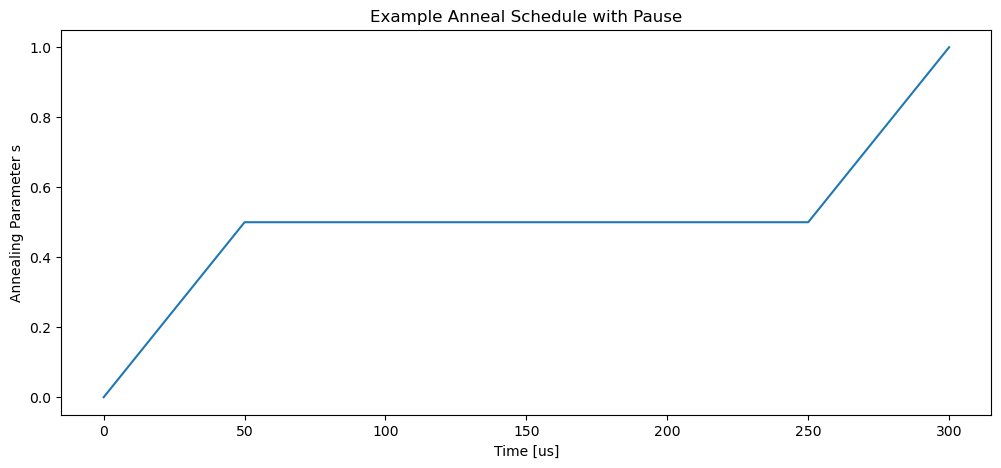

In [11]:
from helpers.draw import plot_schedule

# Print the full anneal schedule
schedule = [[0.0, 0.0], [50.0, 0.5], [250.0, 0.5], [300, 1.0]]
print("Schedule: %s" % schedule)

# Plot the anneal schedule
plot_schedule(schedule, "Example Anneal Schedule with Pause")

### Quench

This section creates an anneal schedule with a quench. At 60% of the way through a 20 $\mu s$ anneal, it sets a slope equivalent to a 2 $\mu s$ anneal. This schedule has three points:

(1) The schedule starts at $[0, 0]$.

(2) The next schedule point is 60% of the way through a 20 $\mu s$ anneal; that is, at 12 $\mu s$. To determine $s$ at time $t = 12 \mu s$, consider the slope of a standard $20 \mu s$ anneal. Recall that the slope is defined as $m_q = \frac{\Delta s}{\Delta t}$, so the slope for the first 12 $\mu s$ is $\frac{1}{20}$ and the next schedule point is $[12, 0.6]$.

(3) The quench slope is equivalent to a 2 $\mu s$ anneal, which has slope $\frac{1}{2}$. This last segment must end with $s(t)=1$, which occurs at time $t=12.8 \mu s$. This makes the last schedule point $[12.8, 1]$.

The next cell plots the anneal schedule with a quench.

Schedule: [[0.0, 0.0], [12.0, 0.6], [12.8, 1.0]]


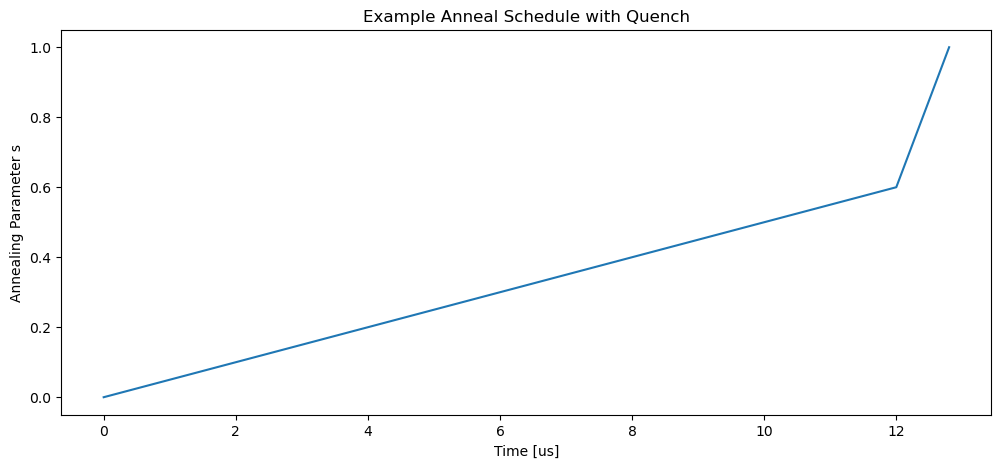

In [12]:
schedule=[[0.0,0.0],[12.0,0.6],[12.8,1.0]]
print("Schedule: %s" % schedule)

plot_schedule(schedule, "Example Anneal Schedule with Quench")

### Pause and Quench

This section creates an anneal schedule with a quench following a 50 $\mu s$ pause 40% of the way through a 100 $\mu s$ anneal. As in section [Pause](#Pause), the schedule needs four points. Again, the resulting slope must not exceed the maximum slope for your system.

The next cell plots the anneal schedule with a pause and a quench.

Schedule: [[0.0, 0.0], [40.0, 0.4], [90.0, 0.4], [91.2, 1.0]]


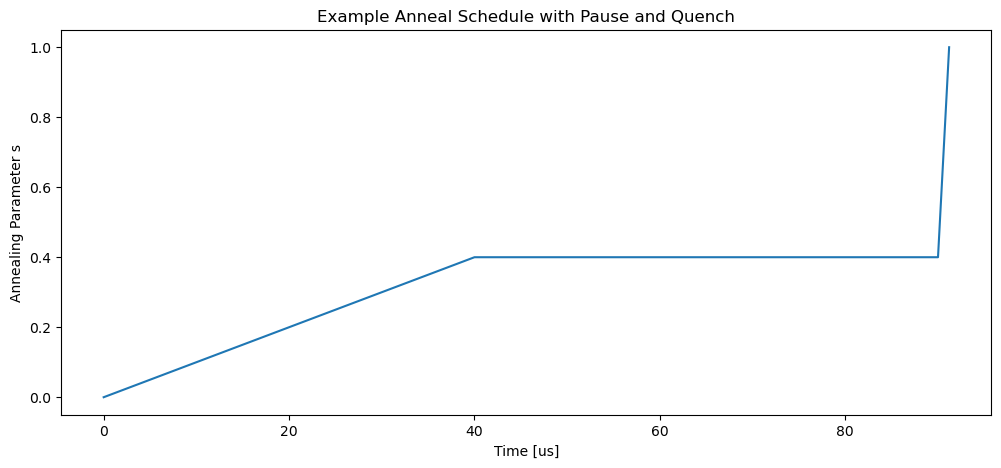

In [13]:
schedule=[[0.0, 0.0], [40.0, 0.4], [90.0, 0.4], [91.2, 1.0]]
print("Schedule: %s" % schedule)

plot_schedule(schedule, "Example Anneal Schedule with Pause and Quench")

## Using Anneal Schedule Features
This section demonstrates how the pause and quench features can improve solutions for an example problem. We use the 16-qubit system shown below, which was studied in https://www.nature.com/articles/ncomms2920, and has an energy gap of 4 between the classical ground state and excited states.

This system is set up as shown in the image below, where dots are qubits with colors representing bias values and lines representing couplings (couplings weights are $-1$).
 
<img src='images/16q_system.png'>

The structure of this problem maps neatly to the Chimera topology of a D-Wave 2000Q QPU: it can be minor-embedded directly into two side-by-side Chimera unit cells, with each problem qubit represented by one qubit on the QPU. On Advantage systems, the problem can be similarly represented by qubits in two of the Chimera unit cell's near-counterpart structure in the Pegasus topology: $K_{4,4}$ bicliques with additional *odd* couplers.

If you were to use a standard heuristic embedder such as [minorminer](https://docs.ocean.dwavesys.com/en/stable/docs_minorminer/source/sdk_index.html), however, some of the problem qubits might be represented by chains of qubits on the QPU. Instead, qubits of two ideal Chimera unit cells are used directly in the `h` and `J` definitions below and the `TilingComposite` composite scans adjacent unit cells on the QPU, finds adjacent pairs in which all the required qubits and couplers are available, and translates the one-to-one minor-embedding of the problem from the first two adjacent pairs to the first available valid pairs.

In [14]:
h = {0: 1.0, 1: -1.0, 2: -1.0, 3: 1.0, 4: 1.0, 5: -1.0, 6: 0.0, 7: 1.0,
     8: 1.0, 9: -1.0, 10: -1.0, 11: 1.0, 12: 1.0, 13: 0.0, 14: -1.0, 15: 1.0}
J = {(9, 13): -1, (2, 6): -1, (8, 13): -1, (9, 14): -1, (9, 15): -1,
     (10, 13): -1, (5, 13): -1, (10, 12): -1, (1, 5): -1, (10, 14): -1,
     (0, 5): -1, (1, 6): -1, (3, 6): -1, (1, 7): -1, (11, 14): -1,
     (2, 5): -1, (2, 4): -1, (6, 14): -1}

In [15]:
from dwave.system import TilingComposite, FixedEmbeddingComposite

tiled_sampler = TilingComposite(sampler, 1, 2, 4)

if tiled_sampler.num_tiles:
    sampler_embedded = FixedEmbeddingComposite(sampler, embedding=tiled_sampler.embeddings[0])
else:
    print("Unable to find two complete unit cells in QPU {}".format(sampler.solver.name))

For reference, the next cell runs the problem with a default anneal schedule.

In [16]:
runs=1000
results = sampler_embedded.sample_ising(h, J, 
    num_reads=runs,
    answer_mode='raw',
    label='Notebook - Anneal Schedule',
    annealing_time=100)

print("QPU time used:", results.info['timing']['qpu_access_time'], "microseconds.")

QPU time used: 287963.16 microseconds.


The following visualization is a histogram of the returned solutions. Typically, the ground state (energy = -20.0) is found in just a fraction of the samples with the default anneal schedule.

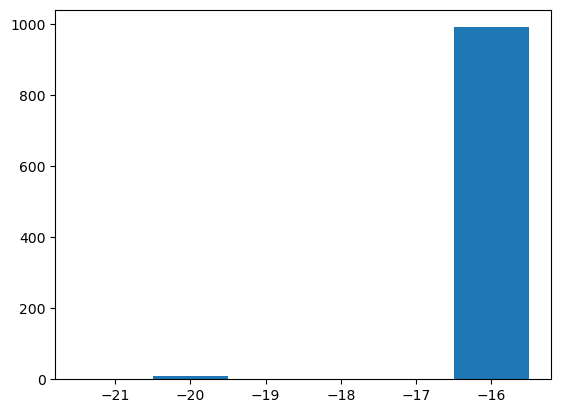

In [17]:
import matplotlib.pyplot as plt 

plt.hist(results.record.energy,rwidth=1,align='left',bins=[-21,-20,-19,-18,-17,-16,-15])
plt.show()

The next cell computes the percentage of ground-state solutions in the returned samples. You can infer the number of required samples you would need to ensure with high probability a good solution to the problem.

In [18]:
import numpy as np

_, counts = np.unique(results.record.energy.reshape(1000,1), axis=0, return_counts=True)
print("Ground state probability: ", counts[0]/runs)

Ground state probability:  0.009


### Using Pause

This section shows some anneal schedules that include a pause. For three different anneal times and three different pause times, ground-state probability is measured as a function of $s_{pause}$, the fraction of the anneal time where the pause occurs. Success rate should increase when the pause occurs near to the freeze-out time.

The schedules used here are all combinations of the following:

  1. Anneal times of 10, 100, or 300 $\mu s$.

  2. Pause duration of 10, 100, or 300 $\mu s$.

  3. Pause starting at various points of $s$ between 0.2 to 0.6.

This section uses saved results from a file. Section [Running the Paused Anneals on the QPU](#Running-the-Paused-Anneals-on-the-QPU) provides the code for you to run these anneals yourself. Note that running these anneals sends a large number of problems to the QPU, so that section takes several minutes to complete and uses a large number of seconds of QPU time.

In [19]:
import pandas as pd
import json
with open("files/saved_pause_results.json", "r") as read_file:
    saved_pause_success_prob = pd.read_json(read_file)

The next cell plots the results:

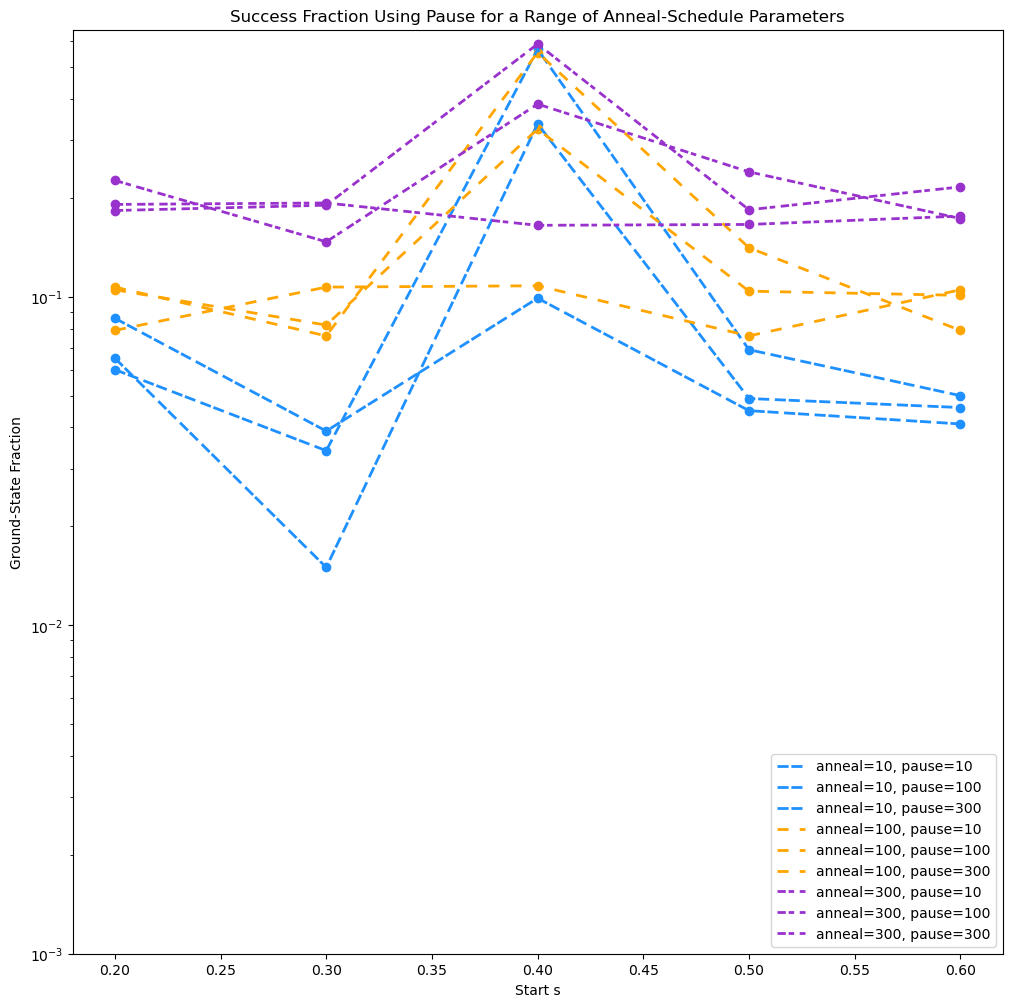

In [20]:
from helpers.draw import plot_success_fraction

pause_plot = plot_success_fraction(saved_pause_success_prob, 
                      "Success Fraction Using Pause for a Range of Anneal-Schedule Parameters", 
                      "pause_duration")

<div class="alert alert-block alert-success">
<b>Exercise:</b> Based on the results above, can you find a better ground state fraction? Define your own anneal schedule in the code block below and see how your results compare.
</div>

Your new point appears as a red circle on the plot. Each time you run this next cell a new red point is added to your previous points.

Success probability:  0.169


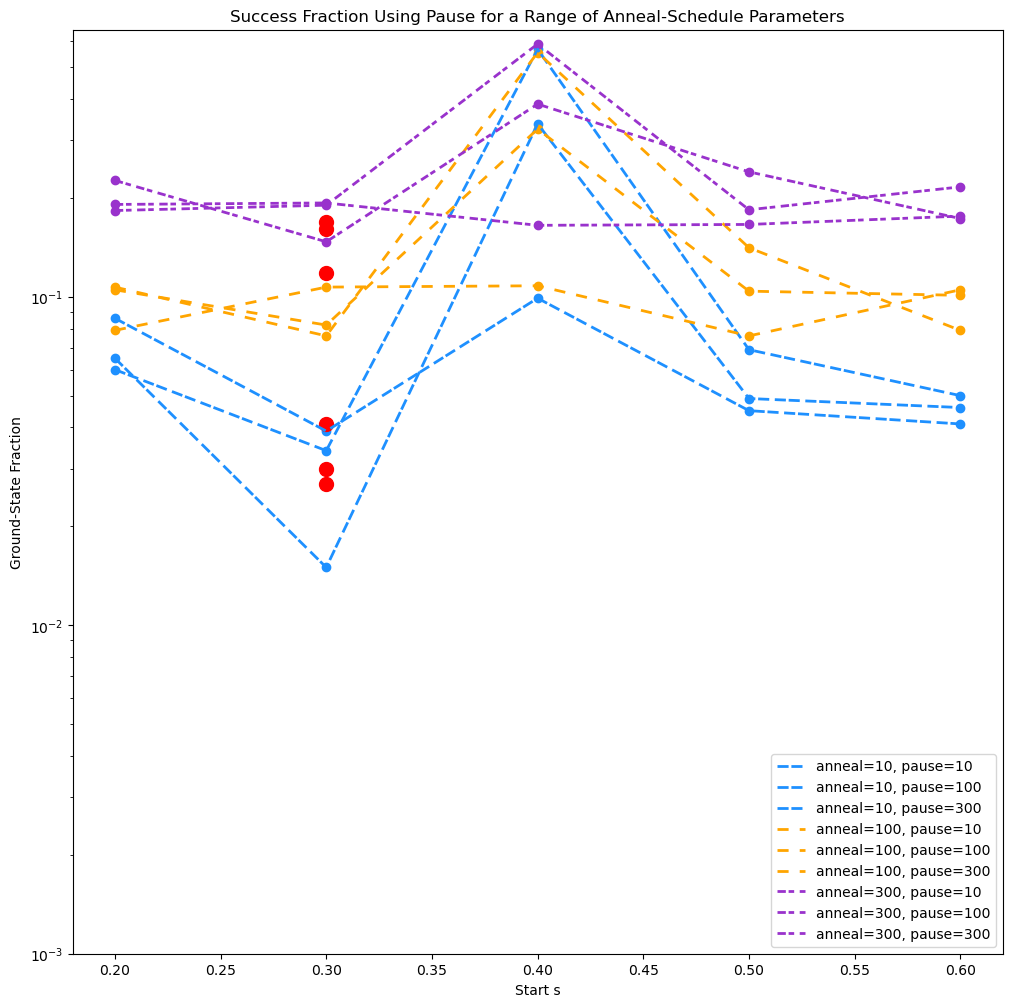

In [28]:
#Update the standard anneal schedule parameters below: 
### original parameters
# anneal_time = 20.0
# pause_duration = 20.0      # Must be greater than 0
# pause_start = 0.3        # Must be between 0 and 1

anneal_time = 300
pause_duration = 500.0      # Must be greater than 0
pause_start = 0.3        # Must be between 0 and 1

#----------------------------------------------------------------
#Leave the code below to run the problem and display the results.
#----------------------------------------------------------------
schedule=[[0.0,0.0],[pause_start*anneal_time,pause_start],[pause_start*anneal_time+pause_duration, pause_start],[anneal_time+pause_duration, 1.0]]
runs=1000
results = sampler_embedded.sample_ising(h, J,
                anneal_schedule=schedule,
                num_reads=runs, 
                answer_mode='raw',
                label='Notebook - Anneal Schedule')
success = np.count_nonzero(results.record.energy == -20.0)/runs
print("Success probability: ",success)

pause_plot["axis"].scatter([pause_start],[success], color="red", s=100)
pause_plot["figure"]

### Quench
This section looks at the effects of using a mid-anneal quench. As above, it sweeps through a range of anneal schedule parameters. Success rates should be low when the quench occurs before freeze out and be similar to a standard anneal when the quench occurs after freeze out.

This section uses saved results from a file. Section [Running the Quenched Anneals on the QPU](#Running-the-Quenched-Anneals-on-the-QPU) provides the code for you to run these anneals yourself. Note that running these anneals sends a large number of problems to the QPU, so that section takes several minutes to complete and uses a large number of seconds of QPU time.

In [29]:
with open("files/saved_quench_results.json", "r") as read_file:
    saved_quench_success_prob = pd.read_json(read_file).replace(0, np.nan)

The next cell plots the results.

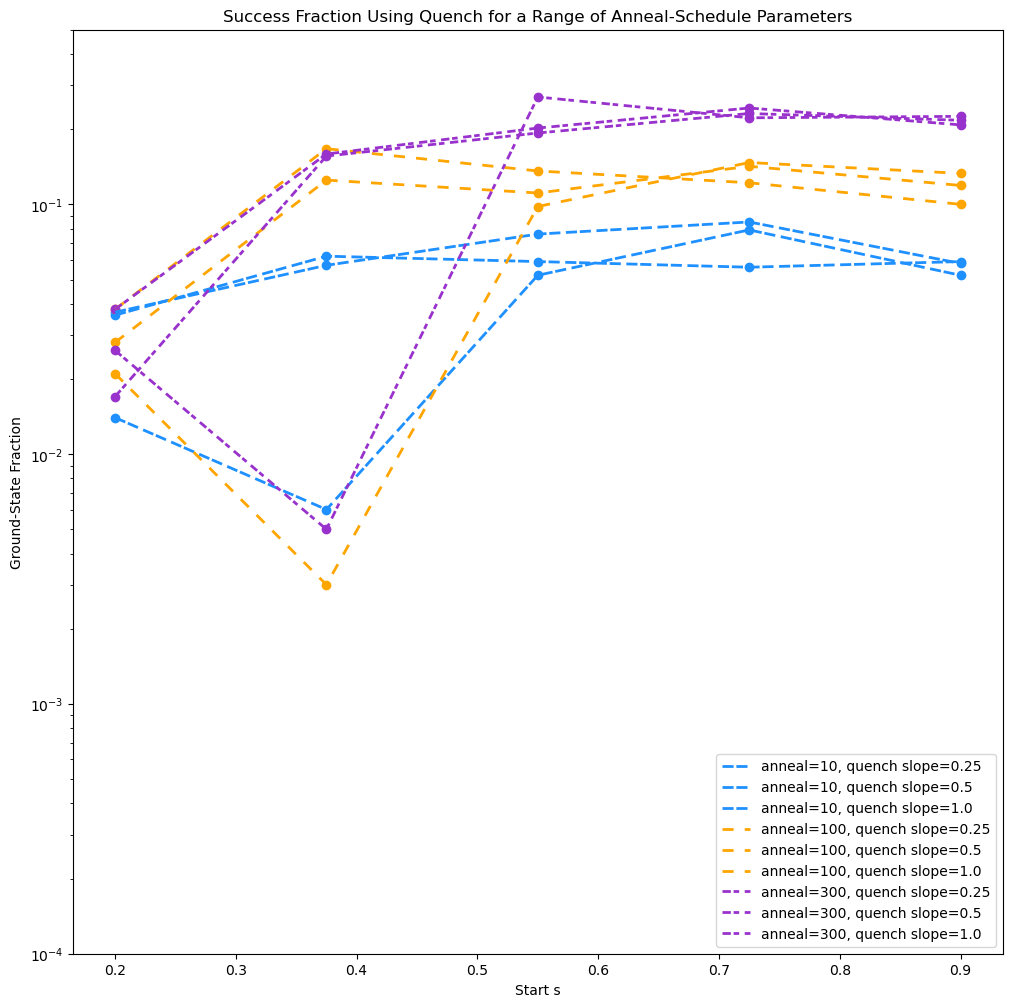

In [30]:
quench_plot = plot_success_fraction(saved_quench_success_prob, 
                      "Success Fraction Using Quench for a Range of Anneal-Schedule Parameters", 
                      "quench_slope")

<div class="alert alert-block alert-success">
<b>Exercise:</b> Based on the results above, can you find a better ground state fraction? Define your own anneal schedule in the code block below and see how your results compare.
</div>

Your new point appears as a red circle on the plot. Each time you run this next cell a new red point is added to your previous points.

Success probability:  0.044


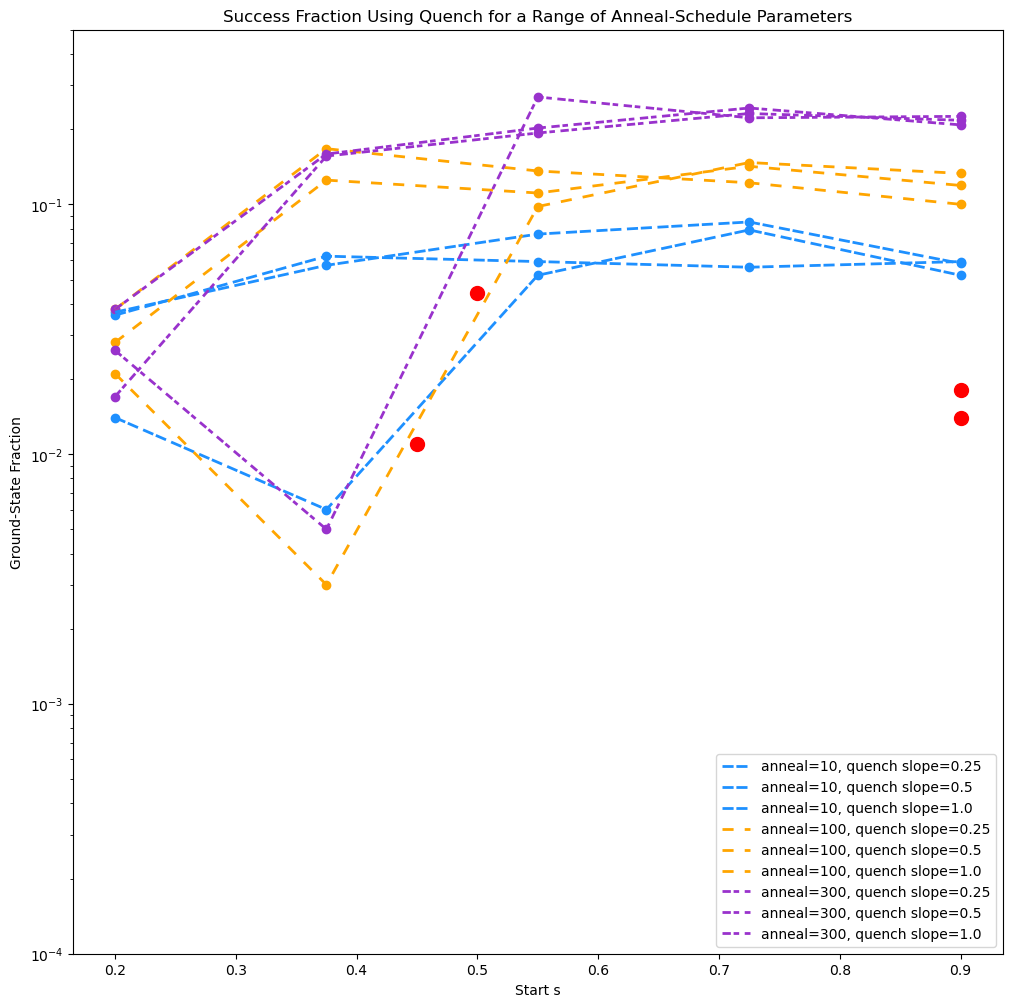

In [34]:
#Update the standard anneal schedule parameters below 

### original parameters
# anneal_time = 50.0
# quench_slope = 1.0      # Must be greater than 0
# quench_start = 0.45      # Must be between 0 and 1
anneal_time = 500.0
quench_slope = 1.0      # Must be greater than 0
quench_start = 0.5      # Must be between 0 and 1

#----------------------------------------------------------------
#Leave the code below to run the problem and display the results.
#----------------------------------------------------------------
schedule=[[0.0,0.0],[quench_start*anneal_time,quench_start],[(1-quench_start+quench_slope*quench_start*anneal_time)/quench_slope, 1.0]]
runs=1000
results = sampler_embedded.sample_ising(h, J,
                anneal_schedule=schedule,
                num_reads=runs, 
                answer_mode='raw',
                label='Notebook - Anneal Schedule')
success = np.count_nonzero(results.record.energy == -20.0)/runs
print("Success probability: ",success)

quench_plot["axis"].scatter([quench_start],[success], color="red", s=100)
quench_plot["figure"]


# Mapping Various Anneal Schedules  on the QPU
Running the code in this section uses tens of seconds of QPU time. You can copy these cells to the respective cells in the previous section that use saved results. 

## Running the Paused Anneals on the QPU

<div class="alert alert-warning" role="alert" style="margin: 10px">
Note that the next cell sends a large number of problems to the QPU, so running takes several minutes to complete and uses a large number of seconds of QPU time.
</div>

In [35]:
# anneal_time=[10.0, 100.0, 300.0]
# pause_duration=[10.0, 100.0, 300.0]

# # Create list of start times
# num_points=5
# s_low=0.2
# s_high=0.6
# pause_start=np.linspace(s_low, s_high, num=num_points)

# success_prob = pd.DataFrame(index=range(len(anneal_time)*len(pause_duration)*len(pause_start)),
#                                 columns=["anneal_time", "pause_duration", "s_feature", "success_frac"],
#                                 data=None)
# counter=0

# print("Starting QPU calls...")
# QPU_time=0.0
# for anneal in anneal_time:
#     for pause in pause_duration:
#         for start in pause_start:
#             schedule=[[0.0,0.0],[start*anneal,start],[start*anneal+pause, start],[anneal+pause, 1.0]]
#             runs=1000
#             results = sampler_embedded.sample_ising(h, J,
#                 anneal_schedule=schedule,
#                 num_reads=runs, 
#                 answer_mode='raw',
#                 label='Notebook - Anneal Schedule')
#             success_prob.iloc[counter]={"anneal_time":anneal, 
#                                         "pause_duration":pause, 
#                                         "s_feature":start,
#                                         "success_frac":np.count_nonzero(results.record.energy == -20.0)/runs}
#             counter+=1
#             QPU_time+=results.info['timing']['qpu_access_time']
#         print("QPU calls remaining: ", len(anneal_time)*len(pause_duration)*len(pause_start)-counter)
            
# print("QPU calls complete using", QPU_time/1000000.0, "seconds of QPU time.")

<!-- ## Running the Quenched Anneals on the QPU

<div class="alert alert-warning" role="alert" style="margin: 10px">
Note that the next cell sends a large number of problems to the QPU, so running takes several minutes to complete and uses a large number of seconds of QPU time.
</div> -->

In [36]:
# anneal_time=[10.0, 100.0, 300.0]
# quench_slopes=[1.0, 0.5, 0.25]

# # start times
# num_points=5
# s_low=0.2
# s_high=0.9
# quench_start=np.linspace(s_low, s_high, num=num_points)

# success_prob = pd.DataFrame(index=range(len(anneal_time)*len(quench_slopes)*len(quench_start)),
#                                 columns=["anneal_time", "quench_slope", "s_feature", "success_frac"],
#                                 data=None)
# counter=0

# print("Starting QPU calls...")
# QPU_time=0.0
# for anneal in anneal_time:
#     for quench in quench_slopes:
#         for start in quench_start:
#             schedule=[[0.0,0.0],[start*anneal,start],[(1-start+quench*start*anneal)/quench, 1.0]]
#             runs=1000
#             results = sampler_embedded.sample_ising(h, J,
#                 anneal_schedule=schedule,
#                 num_reads=runs, 
#                 answer_mode='raw',
#                 label='Notebook - Anneal Schedule')
#             success_prob.iloc[counter]={"anneal_time":anneal, 
#                                         "quench_slope":quench, 
#                                         "s_feature":start,
#                                         "success_frac":np.count_nonzero(results.record.energy == -20.0)/runs}
#             counter+=1
#             QPU_time+=results.info['timing']['qpu_access_time']
#         print("QPU calls remaining: ", len(anneal_time)*len(quench_slopes)*len(quench_start)-counter)
            
# print("QPU calls complete using", QPU_time/1000000.0, "seconds of QPU time.")

Copyright &copy; 2021 D-Wave Systems, Inc

The software is licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This Jupyter Notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>